# Reto AD2023

## Descripción 

El reto consiste en desarrollar un sistema multiagente para resolver una tarea cooperativa en un entorno 20x20 dinámicamente cambiante. El entorno del sistema multiagente es un mundo similar a una cuadrícula donde los agentes pueden moverse de su posición a una celda vecina si ya no hay ningún agente en esa ranura. En este entorno, la comida puede aparecer en cualquier celda menos en una. La celda especial, en la que no puede aparecer comida, se considera un depósito donde los agentes pueden traer y almacenar su comida. Un agente puede sólo puede saber si hay comida en una celda, si está visitándola. Inicialmente, la comida se coloca en algunas celdas aleatorias. Durante la ejecución, puede aparecer comida adicional dinámicamente en celdas seleccionadas al azar, excepto en la celda del depósito. Los agentes pueden tener/desempeñar diferentes roles (como explorador o recolector), comunicarse y cooperar para encontrar y recolectar alimentos de manera eficiente y efectiva

## Puntos a considerar

- Inicialmente no hay comida en el entorno.
- La semilla para generación de números aleatorios será 12345.
- El depósito será generado al azar.
- Cada 5 segundos se colocará una unidad de comida en algunas celdas.
- La cantidad de celdas en las que colocará una unidad comida será definida al azar (entre 2 y 5 celdas).
- Se colocará un total de 47 unidades de comida.
- Número total de pasos (steps): 1500.
- La cantidad total de alimentos que se puede almacenar en el depósito es infinito.
- Hay un total de 5 agentes.
- Cuando una unidad de comida es encontrado por un explorador o por un agente que ya lleva la comida, la posición de la comida se marca y se comunica a otros agentes.
- Cuando un recolector encuentra una unidad comida, lo carga (gráficamente deberá cambia su forma para indicar que lleva comida). La capacidad máxima de comida que puede llevar un agentes es UNA unidad de comida.
- Inicialmente, los agentes no son informados sobre la posición del depósito, pero una vez que lo encuentran, todos saben dónde está.

____

### Imports

In [945]:
from mesa import Agent, Model
from mesa.time import SimultaneousActivation
from mesa.space import SingleGrid
from mesa.datacollection import DataCollector

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt 
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

import numpy as np
import pandas as pd
import random 

In [946]:
SEED = 12345
MAX_STEPS = 10000
MAX_AGENTS = 5
MAX_FOOD = 47
GRID_SIZE = 20

### Agent(s)

In [947]:
class RobotAgent(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        # Attribute to set if the agent is carrying food or not
        self.is_carrying = False
        # Attribute to store the position of the deposit
        self.deposit_cell = None
        # Attribute to store the position of where the food is
        self.food_cell = None
    
    def step(self):
        # If the agent doesn't have the deposit set, in the case the deposit has been found, then set it
        if self.deposit_cell == None:
            if self.deposit_found():
                self.deposit_cell = self.get_deposit_cell()
                print(f"DEPOSIT CELL FOUND FOR ME!: {self.deposit_cell}")

        # Check if a cell with food has been found
        self.food_cell = self.get_food_cells()

        # Obtain the current position of the cell
        x, y = self.pos

        # Variable to store the food of the cell
        food_in_cell = self.get_food_in_cell(x, y)

        # If the current cell has food and the model doesn't have set a cell with food, then set the current cell and pick food
        if food_in_cell > 0:
            if self.food_cell == None and self.is_carrying:
                self.add_food_cell(x, y)
            # Pick the food of the current cell if it's not carrying
            if not self.is_carrying:
                self.pick_food(x, y)
        # If the cell has a value of -1, then the agent is at the deposit
        elif food_in_cell < 0:
            # If the deposit hadn't been found yet, then set it to True
            if not self.deposit_found():
                self.set_deposit_found()
            # If the agent is carrying then place the food on the deposit
            if self.is_carrying:
                self.place_food()
        # If the cell where the agent picked food had 1 food, then it has 0 now, so it should be erased from the food cells array in the model
        if food_in_cell >= 1:
            self.delete_food_cell(x, y)
        
        # Move the agent
        self.move()

    # Move the agent
    def move(self):
        # Variables to store the new x and y positions
        new_x, new_y = self.pos

        # If a cell with food has been found
        if self.food_cell != None:
            # If the agent is carrying food and the deposit has been found
            if self.is_carrying and self.deposit_cell != None:
                # If the cell in x is less than the position of the agent, then subtract one in x
                if self.deposit_cell[0] < self.pos[0]:
                    new_x -= 1
                # If the cell in x is more than the position of the agent, then add one in x
                elif self.deposit_cell[0] > self.pos[0]:
                    new_x += 1
                    
                # If the cell in y is less than the position of the agent, then subtract one in y
                if self.deposit_cell[1] < self.pos[1]:
                    new_y -= 1
                # If the cell in y is more than the position of the agent, then add one in y
                elif self.deposit_cell[1] > self.pos[1]:
                    new_y += 1

                # Check if the new position is occupied
                if self.model.grid.is_cell_empty((new_x, new_y)):
                    # If not, move the agent to the new coordinates
                    self.model.grid.move_agent(self, (new_x, new_y))
                else:
                    # If the new position is occupied, try moving only in the x axis
                    if self.model.grid.is_cell_empty((new_x, self.pos[1])):
                        self.model.grid.move_agent(self, (new_x, self.pos[1]))
                    # If the new x position is also occupied, try moving only in the y axis
                    elif self.model.grid.is_cell_empty((self.pos[0], new_y)):
                        self.model.grid.move_agent(self, (self.pos[0], new_y))
                    # If both positions are occupied, don't move
            elif self.is_carrying:
                # Move to a cell which doesn't have an agent
                possible_moves = [cell for cell in self.model.grid.get_neighborhood(self.pos, moore=True, include_center=False) if self.model.grid.is_cell_empty(cell)]

                # If there are possible moves then move to a random cell
                if possible_moves:
                    new_position = random.choice(possible_moves)
                    self.model.grid.move_agent(self, new_position)
                    
            # If the agent is not carrying then move to the food cell
            else: 
                # If the cell in x is less than the position of the agent, then subtract one in x
                if self.food_cell[0] < self.pos[0]:
                    new_x -= 1
                # If the cell in x is more than the position of the agent, then add one in x
                elif self.food_cell[0] > self.pos[0]:
                    new_x += 1
                    
                # If the cell in y is less than the position of the agent, then subtract one in y
                if self.food_cell[1] < self.pos[1]:
                    new_y -= 1
                # If the cell in y is more than the position of the agent, then add one in y
                elif self.food_cell[1] > self.pos[1]:
                    new_y += 1

                # Check if the new position is occupied
                if self.model.grid.is_cell_empty((new_x, new_y)):
                    # If not, move the agent to the new coordinates
                    self.model.grid.move_agent(self, (new_x, new_y))
                else:
                    # If the new position is occupied, try moving only in the x axis
                    if self.model.grid.is_cell_empty((new_x, self.pos[1])):
                        self.model.grid.move_agent(self, (new_x, self.pos[1]))
                    # If the new x position is also occupied, try moving only in the y axis
                    elif self.model.grid.is_cell_empty((self.pos[0], new_y)):
                        self.model.grid.move_agent(self, (self.pos[0], new_y))
                    # If both positions are occupied, don't move

        # If a cell with food hasn't been found, then move random
        else:
            # Move to a cell which doesn't have an agent
            possible_moves = [cell for cell in self.model.grid.get_neighborhood(self.pos, moore=True, include_center=False) if self.model.grid.is_cell_empty(cell)]

            # If there are possible moves then move to a random cell
            if possible_moves:
                new_position = random.choice(possible_moves)
                self.model.grid.move_agent(self, new_position)

    # Method to  pick food from the cell
    def pick_food(self, x, y):
        self.model.pick_food(x, y)
        self.is_carrying = True

     # Method to place the food in the deposit
    def place_food(self):
        self.model.place_food()
        self.is_carrying = False

    # Method to get the amount of food in a cell
    def get_food_in_cell(self, x, y):
        return self.model.get_food_in_cell(x, y)
    
    # Method to check if a cell with food has been found
    def get_food_cells(self):
        # Get the list of food cells from the model
        food_cells = self.model.get_food_cells()

        # If there are no food cells, return None
        if not food_cells:
            return None

        # Calculate the distance from the agent to each food cell
        distances = [(cell, self.distance_to(cell)) for cell in food_cells]

        # Sort the distances list by the distance, in ascending order
        distances.sort(key=lambda x: x[1])

        # Return the cell part of the first tuple in the sorted list (the closest cell)
        return distances[0][0]
    
    # Calculate the distance between the agent a cell
    def distance_to(self, cell):
        x1, y1 = self.pos
        x2, y2 = cell
        return ((x2 - x1) ** 2 + (y2 - y1) ** 2) ** 0.5
    
    # Method to set the cell with food
    def add_food_cell(self, x, y):
        self.model.add_food_cell(x, y)

    # Method to delete a certain cell with food from the array of cells with food
    def delete_food_cell(self, x, y):
        self.model.delete_food_cell(x, y)
    
    # Get the position of the deposit
    def get_deposit_cell(self):
        return self.model.get_deposit_cell()
    
    # Check if the deposit has been found yet
    def deposit_found(self):
        return self.model.deposit_found()
    
    def set_deposit_found(self):
        self.model.set_deposit_state(True)

### Methods for DataCollector

In [948]:
def get_agents(model):
    grid = np.zeros((model.grid.width, model.grid.height))
    for agent in model.schedule.agents:
        x, y = agent.pos
        grid[x][y] = 10  # Puedes ajustar este valor según tus necesidades
    return grid

### Model

In [949]:
class FoodModel(Model):
    def __init__(self, width, height, num_agents, max_food):
        self.random.seed(SEED)
        self.num_agents = num_agents
        self.max_food = max_food
        self.food_generated = 0
        self.grid = SingleGrid(width, height, torus=True)
        self.schedule = SimultaneousActivation(self)
        self.datacollector = DataCollector(
            model_reporters={"Agents": get_agents},
        )
        self.deposit_cell = (random.randint(0, GRID_SIZE-1), random.randint(0, GRID_SIZE-1))
        self.deposit_state = False
        self.food_matrix = np.zeros((GRID_SIZE, GRID_SIZE))
        self.food_found = []
        self.food_deposited = 0
        self.generate_agents(num_agents)
        self.completed = False
        self.steps = 0
        print(f"Deposit: {self.deposit_cell}")

        self.food_matrix[self.deposit_cell[0]][self.deposit_cell[1]] = -1

    def step(self):
        self.schedule.step()
        self.generate_food()
        self.simulation_completed()
        self.datacollector.collect(self)
        self.steps += 1

    def generate_agents(self, num_agents):
        for i in range(num_agents):
            while True:
                x, y = random.randint(0, GRID_SIZE-1), random.randint(0, GRID_SIZE-1)

                if (x, y) != self.deposit_cell and self.food_matrix[x][y] == 0 and self.grid.is_cell_empty((x, y)):
                    break

            agent = RobotAgent(i, self)
            self.schedule.add(agent)
            self.grid.place_agent(agent, (x, y))
            # print(f"Agent {i} placed in cell ({x}, {y})")

    def generate_food(self):
        if self.schedule.steps % 5 == 0:
            num_cells_for_food = random.randint(2, 5)
            # print(f"Generating food in {num_cells_for_food} cells")

            for _ in range(num_cells_for_food):
                if self.food_generated < self.max_food:
                    while True:
                        x, y = random.randint(0, GRID_SIZE-1), random.randint(0, GRID_SIZE-1)
                        cell_occupied = any(agent.pos == (x, y) for agent in self.schedule.agents)
                        if (x, y) != self.deposit_cell and not cell_occupied:
                            break
                    self.food_matrix[x][y] += 1
                    self.food_generated += 1
                    # print(f"Food generated: {self.food_generated} in cell ({x}, {y})")

    def pick_food(self, x, y):
        self.food_matrix[x][y] -= 1

    def place_food(self):
        self.food_deposited += 1
    
    def get_food_cells(self):
        return self.food_found
    
    # Return de amount of food in the cell
    def get_food_in_cell(self, x, y):
        return self.food_matrix[x][y]
    
    # Set the amount of food in the cell - Pending approve
    def add_food_cell(self, x, y):
        self.food_found.append((x, y))

    def get_deposit_cell(self):
        print(f"Step: {self.steps}")
        return self.deposit_cell
    
    def deposit_found(self):
        return self.deposit_state
    
    def set_deposit_state(self, state):
        self.deposit_state = state
    
    def delete_food_cell(self, x, y):
        cell_to_remove = (x, y)
        if cell_to_remove in self.food_found:
            self.food_found.remove(cell_to_remove)

    def get_food_deposited(self):
        return self.food_deposited

    # Check if the simulation has been completed
    def simulation_completed(self):
        #if self.food_generated == self.max_food and self.food_matrix.sum() == 0:
        if self.food_deposited == self.max_food:
            self.completed = True

    def is_complete(self):
        return self.completed
    
    def get_steps(self):
        return self.steps

In [950]:
model = FoodModel(GRID_SIZE, GRID_SIZE, MAX_AGENTS, MAX_FOOD)
for i in range(MAX_STEPS):
    model.step()
    if model.is_complete():
        break

Deposit: (1, 19)
Step: 93
DEPOSIT CELL FOUND FOR ME!: (1, 19)
Step: 93
DEPOSIT CELL FOUND FOR ME!: (1, 19)
Step: 93
DEPOSIT CELL FOUND FOR ME!: (1, 19)
Step: 93
DEPOSIT CELL FOUND FOR ME!: (1, 19)
Step: 94
DEPOSIT CELL FOUND FOR ME!: (1, 19)


STEPS: 7064
FOOD DEPOSITED: 47


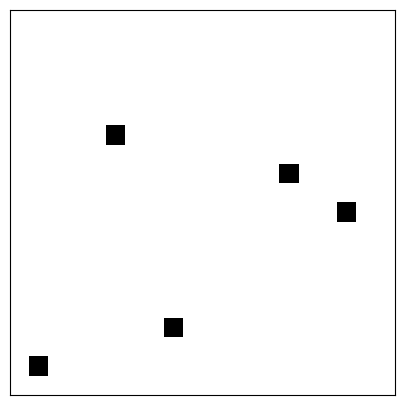

In [951]:
all_grid = model.datacollector.get_model_vars_dataframe()
fig, axis = plt.subplots(figsize=(5, 5))
axis.set_xticks([])
axis.set_yticks([])
patch = plt.imshow(all_grid.iloc[0][0], cmap = plt.cm.binary)

def animate(frame):
    patch.set_data(all_grid.iloc[frame][0])

anim = animation.FuncAnimation(fig, animate, frames=model.get_steps())

print(f"STEPS: {model.get_steps()}")
print(f"FOOD DEPOSITED: {model.get_food_deposited()}")

In [952]:
#anim